In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2
from ResNet import ResNet18,ResNet34,ResNet50,ResNet101

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [9]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=2)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(test, batch_size=32,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


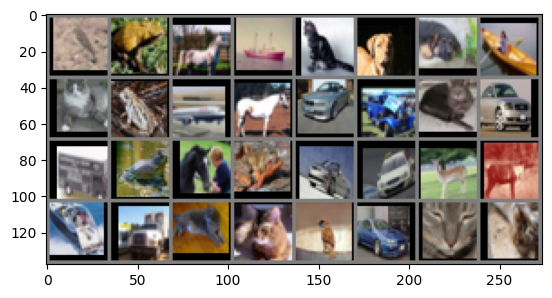

 bird  frog horse  ship   cat   dog   dog  ship   cat  frog plane horse   car   car   cat   car truck  frog horse  frog   car   car  deer  deer  ship truck   cat   cat  bird   car   cat   cat


In [10]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Hàm để hiển thị hình ảnh
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Lấy một batch từ trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Hiển thị hình ảnh
imshow(torchvision.utils.make_grid(images))

# In nhãn
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

In [21]:

# Hàm khởi tạo ResNet50, criterion, optimizer và scheduler
def initialize_model(model,num_classes):
    return model(num_classes).to('cuda')

# Hàm huấn luyện mô hình với early stopping
def train_model(model, criterion, optimizer, scheduler, trainloader, testloader, num_epochs, patience):
    train_losses = []
    train_accuracies=[]
    test_accuracies = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        losses = []
        correct_train = 0
        total_train = 0

        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        avg_train_loss = np.mean(losses)
        avg_train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
        scheduler.step(avg_train_loss)
        
        # Đánh giá trên tập kiểm tra
        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        avg_test_loss = test_loss / len(testloader)
        test_accuracies.append(accuracy)
        test_losses.append(avg_test_loss)
        if (epoch+1) %5==0:
            print(f'[Epoch {epoch + 1}/{num_epochs}] Test Loss: {avg_test_loss:.3f}, Test Accuracy: {accuracy:.2f}%')

        # Kiểm tra điều kiện dừng sớm
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    print('Finished Training')
    return train_losses, train_accuracies,test_accuracies, test_losses



# Main

model= initialize_model(ResNet50,10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
EPOCHS = 20
PATIENCE = 5  # Số epoch mà nếu không có cải thiện sẽ dừng sớm
train_losses, train_accuracies,test_accuracies, test_losses = train_model(model, criterion, optimizer, scheduler, trainloader, testloader, EPOCHS, PATIENCE)



[Epoch 5/20] Test Loss: 0.863, Test Accuracy: 70.42%
[Epoch 10/20] Test Loss: 0.615, Test Accuracy: 79.45%
[Epoch 15/20] Test Loss: 0.577, Test Accuracy: 80.84%
[Epoch 20/20] Test Loss: 0.568, Test Accuracy: 81.05%
Finished Training


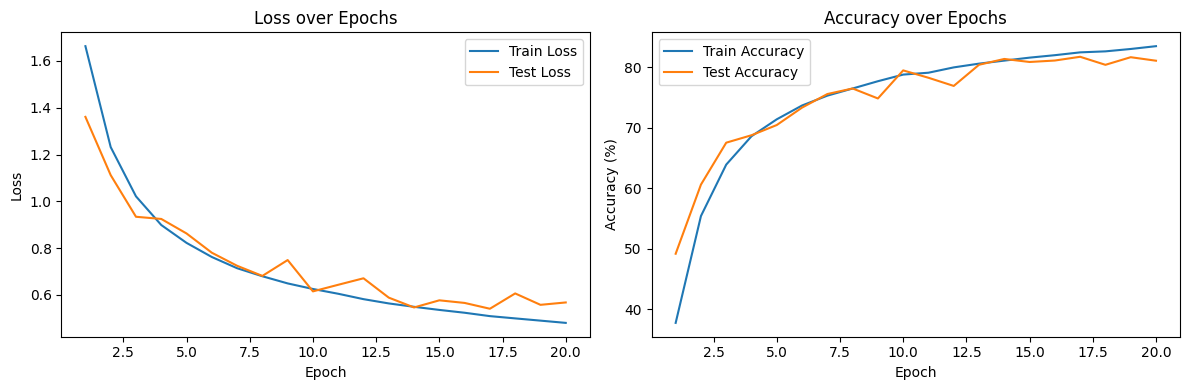

In [22]:
# Hàm vẽ biểu đồ hàm mất mát và độ chính xác
def plot_metrics(train_losses,train_accuracies, test_accuracies, test_losses):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy over Epochs')
    
    plt.tight_layout()
    plt.show()
    
plot_metrics(train_losses, train_accuracies,test_accuracies, test_losses)
